## Техническое задание
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

#### Описание данных
Данные состоят из файлов, полученных из разных источников:

- contract.csv — информация о договоре;

- personal.csv — персональные данные клиента;

- internet.csv — информация об интернет-услугах;

- phone.csv — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

#### Описание полей данных:
- BeginDate – дата начала пользования услугами,

- EndDate – дата окончания пользования услугами,

- Type – тип оплаты: ежемесячный, годовой и тд,

- PaperlessBilling – электронный документ об оплате,

- PaymentMethod – способ оплаты,

- MonthlyCharges – ежемесячные траты на услуги,

- TotalCharges – всего потрачено денег на услуги,

- Dependents – наличие иждивенцев,

- Senior Citizen – наличие пенсионного статуса по возрасту,

- Partner – наличие супруга(и),

- MultipleLines – наличие возможности ведения параллельных линий во время звонка.

### План работы

1. Техническое задание.

2. Импорт библиотек и загрузка данных

3. Изучение полученных данных.

4. Предобработка данных.

5. Исследовательский анализ данных.

6. Подготовка данных к расчету модели. (Кодирование категориальных переменных ,разбиение данных).

7.  Моделирование (определение исследуемых моделей, тестовая модель, подбор гиперпараметров).

8. Сравнение моделей, определение порога нужных метрик,важность признаков.

9. Общий вывод.

10. Отчет.

## Импорт библиотек и загрузка данных.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import time
from sklearn.utils import shuffle


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve, confusion_matrix
pd.set_option('display.max_columns', None)

RANDOM_STATE = 250722

alpha = 0.05

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

## Изучение полученных данных.

In [3]:
def analyze_df(df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    display(df.head(5))
    display(df.describe())
    df.info()

In [4]:
analyze_df(contract)

Количество стобцов: 8
Количество строк: 7043


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [6]:
contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

#####  Вывод  
-  В данных нет пропусков
- BeginDate и EndDate надо перевести в формат даты
- No в EndDate означает, что пользователь продолжает пользоваться услугами - это целевой признак
- После выделения целевого признака надо будет заменить No на 01.02.2020 в EndDate
- TotalCharges надо перевести в числовой тип
- К PaymentMethod, Type и PaperlessBilling надо применить One Hot Encoding

In [7]:
analyze_df(personal)

Количество стобцов: 5
Количество строк: 7043


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


##### Выводы:

 - В данных нет пропусков
 - К gender, Partner и Dependents надо применить One Hot Encoding

In [8]:
analyze_df(internet)

Количество стобцов: 8
Количество строк: 5517


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7439-DKZTW,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [9]:
internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

##### Выводы:

- В данных нет пропусков
- Данные есть не по всем клиентам
- К InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies надо применить One Hot Encoding

In [10]:
analyze_df(phone)

Количество стобцов: 2
Количество строк: 6361


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,4983-CLMLV,No
freq,1,3390


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


##### Выводы:

- В данных нет пропусков
- Данные есть не по всем клиентам
- К MultipleLines надо применить One Hot Encoding

## Предобработка данных.

Для удобства приведем названия столбцов к нижнему регистру:

In [11]:

contract.columns = contract.columns.str.lower()
personal.columns = personal.columns.str.lower()
internet.columns = internet.columns.str.lower()
phone.columns = phone.columns.str.lower()

Добавим целевой признак churn, который будет означать отказался клиент от услуг или нет.
Если значение в столбце enddate равно "No", то значит клиент не ушел и целевой признак равен 0.
Если дата ухода есть, то целевой признак равен 1.

In [12]:
contract['churn'] = (contract['enddate'] != 'No').astype(int)
contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


Заменим все значения "No" в EndDate на начальную  дату датасета - 01.02.2020

In [13]:
contract['enddate'] = contract['enddate'].replace(['No'], ['2020-02-01'])
print(contract[contract['enddate'] == 'No'].shape[0])

0


Переведем enddate и begindate в формат даты

In [14]:
contract['begindate'] = pd.to_datetime(contract['begindate'], format='%Y-%m-%d')
contract['enddate'] = pd.to_datetime(contract['enddate'], format='%Y-%m-%d')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   object        
 8   churn             7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 495.3+ KB


Заведем новый столбец totaldays, который будет означать, сколько пользователь пользовался услугами

In [15]:
contract['totaldays'] = (contract['enddate'] - contract['begindate']).dt.days

Переведем totalcharges в числовой тип

In [16]:
contract['totalcharges'] = pd.to_numeric(contract['totalcharges'], errors ='coerce')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   churn             7043 non-null   int64         
 9   totaldays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


В столбце totalcharges есть пропуски, посмотрим на них.


In [17]:
contract[contract['totalcharges'].isnull()]

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,totaldays
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


Видно, что все эти клиенты подключены всего 1 день.Это новички. Заполним пропуски в totalcharges на 0

In [18]:
contract['totalcharges'] = contract['totalcharges'].fillna(0)
contract['totalcharges'].isnull().sum()

0

Объединим все таблицы в один датафрейм

In [19]:
churn = contract \
    .merge(personal, how='left', on='customerid') \
    .merge(internet, how='left', on='customerid') \
    .merge(phone, how='left', on='customerid')

Уникальность customerid

In [20]:
churn['customerid'].is_unique

True

Установим CustomerID в качестве индекса

In [21]:
churn = churn.set_index('customerid')

In [22]:
analyze_df(churn)

Количество стобцов: 21
Количество строк: 7043


,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,totaldays,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
customerid,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


,monthlycharges,totalcharges,churn,totaldays,seniorcitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.265370,985.996166,0.162147
std,30.090047,2266.794470,0.441561,747.587844,0.368612
min,18.250000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000,0.000000
50%,70.350000,1394.550000,0.000000,883.000000,0.000000
75%,89.850000,3786.600000,1.000000,1676.000000,0.000000
max,118.750000,8684.800000,1.000000,2191.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         7043 non-null   datetime64[ns]
 1   enddate           7043 non-null   datetime64[ns]
 2   type              7043 non-null   object        
 3   paperlessbilling  7043 non-null   object        
 4   paymentmethod     7043 non-null   object        
 5   monthlycharges    7043 non-null   float64       
 6   totalcharges      7043 non-null   float64       
 7   churn             7043 non-null   int64         
 8   totaldays         7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  seniorcitizen     7043 non-null   int64         
 11  partner           7043 non-null   object        
 12  dependents        7043 non-null   object        
 13  internetservice   5517 non-null   object        
 14  onlinesecurity

Пропуски в internetservice, onlinesecurity, onlinebackup, deviceprotection, techsupport, streamingtv, streamingmovies и multiplelines скорее всего означают, что у клиентов  данные услуги не подключены. Заменим пропуски на "No"

In [23]:
for column in ('internetservice','onlinesecurity', 'onlinebackup', 'deviceprotection',\
               'techsupport', 'streamingtv', 'streamingmovies' , 'multiplelines'):
    churn[column] = churn[column].fillna('No')

In [24]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         7043 non-null   datetime64[ns]
 1   enddate           7043 non-null   datetime64[ns]
 2   type              7043 non-null   object        
 3   paperlessbilling  7043 non-null   object        
 4   paymentmethod     7043 non-null   object        
 5   monthlycharges    7043 non-null   float64       
 6   totalcharges      7043 non-null   float64       
 7   churn             7043 non-null   int64         
 8   totaldays         7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  seniorcitizen     7043 non-null   int64         
 11  partner           7043 non-null   object        
 12  dependents        7043 non-null   object        
 13  internetservice   7043 non-null   object        
 14  onlinesecurity

## Исследовательский анализ данных.

In [25]:
numeric_columns = ['monthlycharges', 'totalcharges','totaldays']# количественные признаки
categorial_columns = [#категориальные признаки
    'type',
    'paperlessbilling',
    'paymentmethod',
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'internetservice', 
    'onlinesecurity', 
    'onlinebackup', 
    'deviceprotection', 
    'techsupport', 
    'streamingtv', 
    'streamingmovies', 
    'multiplelines',
]

In [26]:
def plot_numerical(df):
    cols = 3
    rows = 2

    plt.figure(figsize=(15, 10))

    idx = 0
    for column in numeric_columns:
        idx += 1 
    
        plt.subplot(rows, cols, idx)
        plt.hist(df[column])
        plt.title(column)
    
    for column in numeric_columns:
        idx += 1 
    
        plt.subplot(rows, cols, idx)
        plt.boxplot(df[column])
        plt.title(column)
        
    plt.show()

    display(df[numeric_columns].describe())

Посмотрим распределение значений для категориальных данных

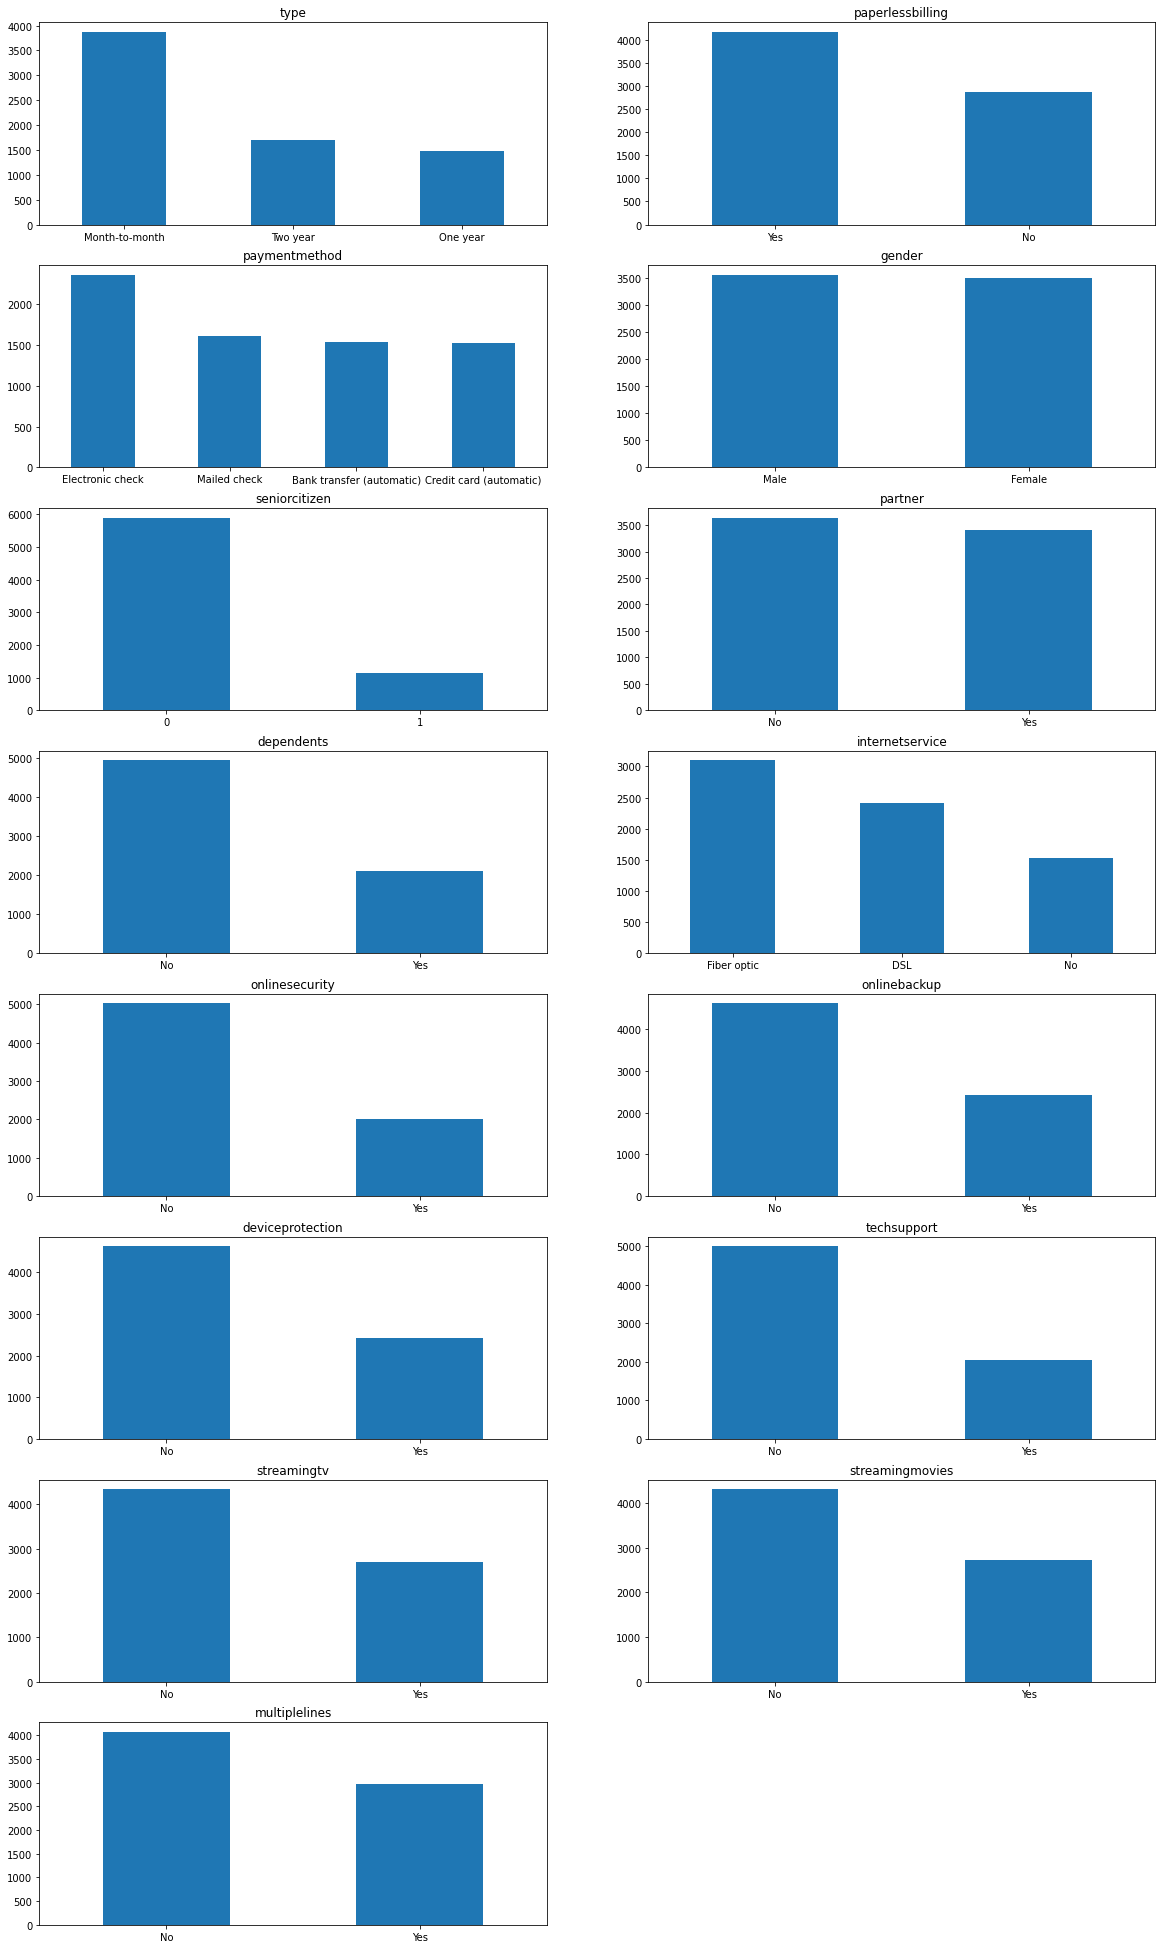

In [27]:
cols = 2
rows = int(np.ceil(len(categorial_columns) / cols))

plt.figure(figsize=(20, 35))

for idx, column in enumerate(categorial_columns):
    ax = plt.subplot(rows, cols, idx + 1)
    
    churn[column].value_counts().plot(
        kind='bar', 
        title=column, 
        ax=ax,
        rot=0,
    )
        
plt.show()

##### Выводы:

- Самый популярный способ оплаты - помесячный
- Люди чаще предпочитают получать счета в электронном виде и оплачивать их при помощи электронного чека
- Мужчин столько же, сколько женщин.
- Люде пенсионного возраста меньше.
- Самый частый способ подключения - оптоволокно
- Дополнительные услуги OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines не пользуются популярностью у пользователей

Посмотрим распределение значений и диаграммы размаха для количественных данных

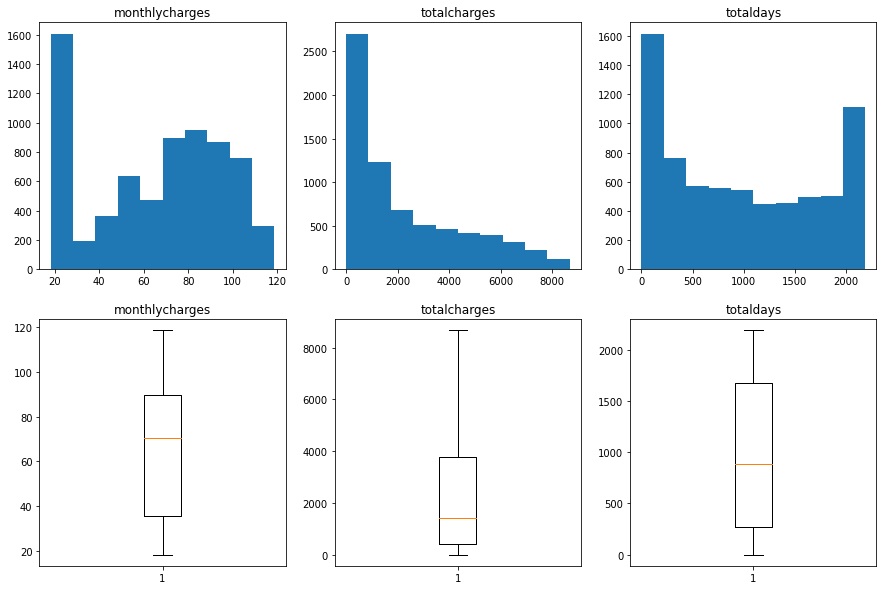

,monthlycharges,totalcharges,totaldays
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,985.996166
std,30.090047,2266.794470,747.587844
min,18.250000,0.000000,0.000000
25%,35.500000,398.550000,273.000000
50%,70.350000,1394.550000,883.000000
75%,89.850000,3786.600000,1676.000000
max,118.750000,8684.800000,2191.000000


In [28]:
plot_numerical(churn)

##### Выводы:

- Значения в столбце totalcharges убывают, в то же время в столбце monthlycharges виден пик в райне 85 - это значит, что пользователи, которые платят за тариф много на долго не остаются
- В столбце totaldays видно 2 пика - в районе новых клиентов и клиентов, которые долго пользуются услугами
- Также у monthlycharges виден пик в районе 20, что является минимальным значением
- Аномальных выбросов нет

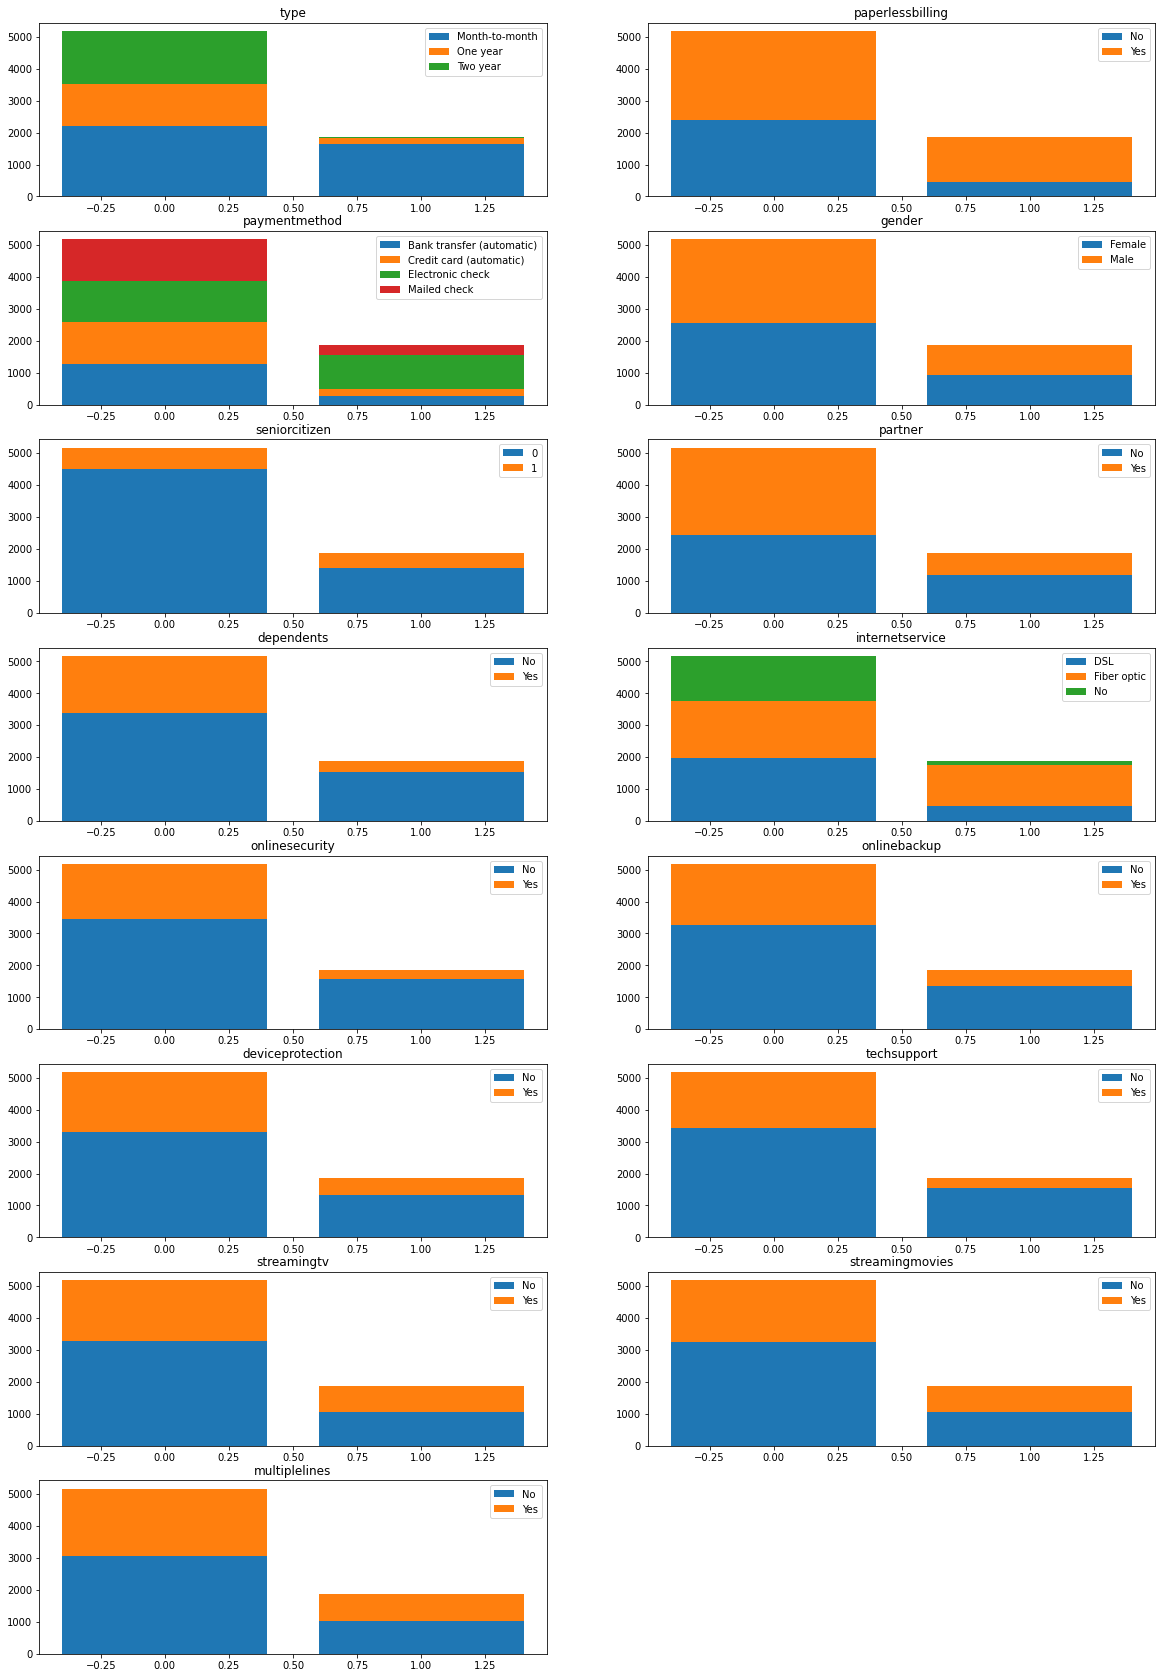

In [29]:
cols = 2
rows = int(np.ceil(len(categorial_columns) / cols))

plt.figure(figsize=(20, 30))

for idx, column in enumerate(categorial_columns):
    churn_grouped = churn.groupby([column, 'churn'])['churn'].count()
    churn_grouped = churn_grouped.unstack()
    
    ax = plt.subplot(rows, cols, idx + 1)

    ax.bar(churn_grouped.T.index, churn_grouped.T[churn_grouped.T.columns[0]], label=churn_grouped.T.columns[0])
    bottom = np.array(churn_grouped.T[churn_grouped.T.columns[0]])
    for color_idx, value in enumerate(churn_grouped.T.columns[1:]): 
        ax.bar(churn_grouped.T.index, churn_grouped.T[value], bottom=bottom, label=value)
        bottom += np.array(churn_grouped.T[value])
    plt.title(column)
    plt.legend()
        
plt.show()

##### Выводы:

- Доля отказов среди тех, кто использует помесячную оплату выше, чем среди тех, кто сразу платит за 1/2 года
- Дополнительные услуги слабо влияют на отказы
- Пользователи использующие "Electronic check" для оплаты чаще отказываются от услуг, возможно в оплате онлайн есть какие-то неудобства
- Пенсионеры уходят чаще
- Если пользователь не пользуется интернетом, то вероятность отказа ниже. Скорее всего это связано с тем, что более возрастные люди не хотят разбираться в том, как сменить поставщика услуг

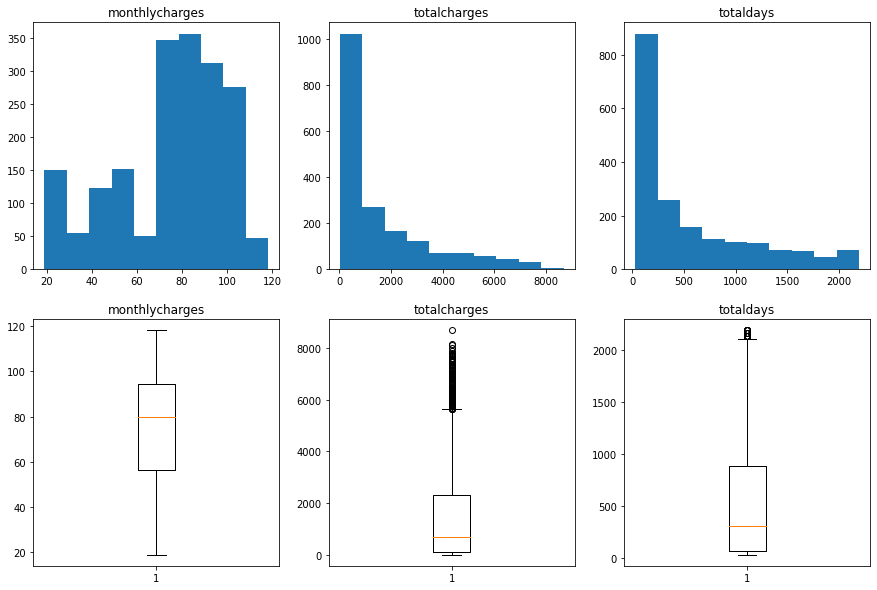

,monthlycharges,totalcharges,totaldays
count,1869.000000,1869.000000,1869.000000
mean,74.441332,1531.796094,547.352060
std,24.666053,1890.822994,594.389607
min,18.850000,18.850000,30.000000
25%,56.150000,134.500000,61.000000
50%,79.650000,703.550000,304.000000
75%,94.200000,2331.300000,883.000000
max,118.350000,8684.800000,2191.000000


In [30]:
plot_numerical(churn[churn['churn'] == 1])

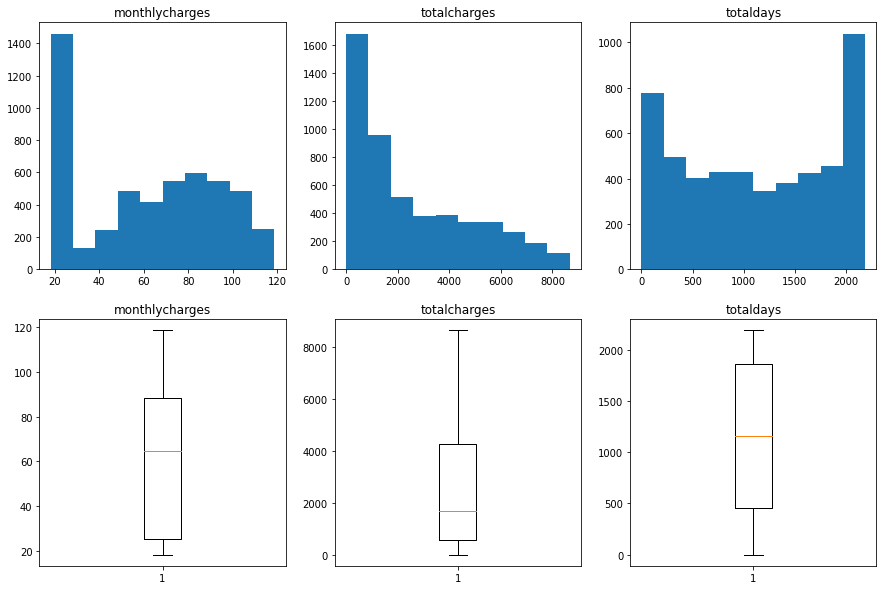

,monthlycharges,totalcharges,totaldays
count,5174.000000,5174.000000,5174.000000
mean,61.265124,2549.911442,1144.447236
std,31.092648,2329.954215,733.897937
min,18.250000,0.000000,0.000000
25%,25.100000,572.900000,457.000000
50%,64.425000,1679.525000,1157.000000
75%,88.400000,4262.850000,1857.000000
max,118.750000,8672.450000,2191.000000


In [31]:
plot_numerical(churn[churn['churn'] == 0])

##### Выводы:

- Чем больше время пользования услугами, тем меньше  вероятность отказа от услуг.
- Отказывались от услуг те, кто платил больше
- Текущие клиенты платят  меньше в месяц, чем те, кто отказался

Рассмотррим матрицу корреляции

In [32]:
churn.corr()['churn'].sort_values(ascending=False)

churn             1.000000
monthlycharges    0.193356
seniorcitizen     0.150889
totalcharges     -0.198324
totaldays        -0.352673
Name: churn, dtype: float64

- чем дольше клиент пользовался услугами, тем меньше вероятность, что он уйдет
- чем выше цена за услуги в месяц, тем больше вероятность, что клиент уйдет

## Подготовка данных к расчету модели.

Удалим ненужные для обучения столбцы begindate и enddate

In [33]:
del churn['begindate'], churn['enddate']

Перекодируем категориальные признаки в количественные с помощью техники OHE

In [34]:
churn = pd.get_dummies(churn, drop_first=True)
churn.head(5)

,monthlycharges,totalcharges,churn,totaldays,seniorcitizen,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,gender_Male,partner_Yes,dependents_Yes,internetservice_Fiber optic,internetservice_No,onlinesecurity_Yes,onlinebackup_Yes,deviceprotection_Yes,techsupport_Yes,streamingtv_Yes,streamingmovies_Yes,multiplelines_Yes
customerid,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,29.85,0,31,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
5575-GNVDE,56.95,1889.50,0,1036,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0
3668-QPYBK,53.85,108.15,1,61,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0
7795-CFOCW,42.30,1840.75,0,1371,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0
9237-HQITU,70.70,151.65,1,61,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


Выделим  целевой показатель churn

In [35]:
target = churn['churn'] 
features = churn.drop(columns=['churn'])

Разделим датафрейм на обучающую и тестовую выбороки

In [36]:
features_train, features_test, target_train, target_test = train_test_split(features, target,\
                                                                            test_size=0.2, random_state=RANDOM_STATE)

Проведем масштабирование количественных признаков

In [37]:
scaler = StandardScaler()

scaler.fit(features_train[numeric_columns])

features_train = features_train.copy()
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])

features_test = features_test.copy()
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

Проверим баланс классов

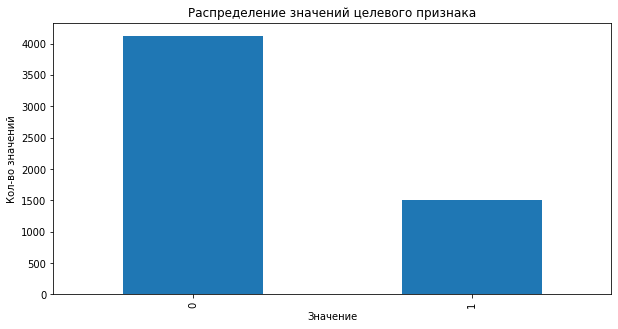

In [38]:
target_train.value_counts().plot(
    kind='bar', 
    figsize=(10, 5), 
    legend=False, 
    title='Распределение значений целевого признака', 
).set(xlabel='Значение', ylabel='Кол-во значений')
plt.show()

Налицо дисбаланс классов, который исправим с помощью upsampling, т.е увеличением числа объектов меньшего класса.

In [39]:
def upsample(features, target, repeat):     
    features_zeros = features[target == 0]     
    features_ones = features[target == 1]     
    target_zeros = target[target == 0]     
    target_ones = target[target == 1] 

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)     
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)     
    
    features_upsampled, target_upsampled = shuffle(         
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)          
    
    return features_upsampled, target_upsampled

In [40]:
features_train, target_train = upsample(features_train, target_train, 3)

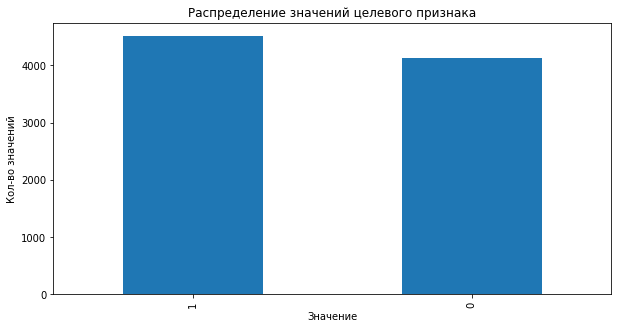

In [41]:
target_train.value_counts().plot(
    kind='bar', 
    figsize=(10, 5), 
    legend=False, 
    title='Распределение значений целевого признака', 
).set(xlabel='Значение', ylabel='Кол-во значений')
plt.show()

Распределение значений целевого признака выправилось

## Моделирование


In [42]:
def plot_roc_curve(target_test, predictions):
    print('ROC-AUC score', roc_auc_score(target_test, predictions))
    
    fpr, tpr, thresholds = roc_curve(target_test, predictions)

    plt.figure(figsize=(11, 5))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая')
    
    plt.show()

LogisticRegression

In [43]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

model = LogisticRegression(solver='lbfgs', n_jobs=-1)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]

{'C': 1000}


ROC-AUC score 0.8564248286342984


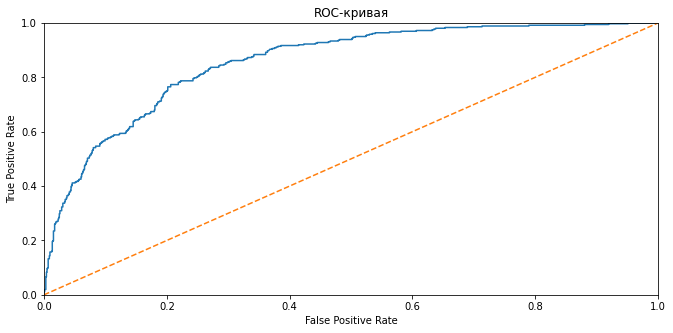

In [44]:
plot_roc_curve(target_test, predicted_probalities)

RandomForestClassifier

In [45]:
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'n_estimators': [10, 50, 100], 
}

model = RandomForestClassifier(random_state=RANDOM_STATE)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]

{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


ROC-AUC score 0.85923475122291


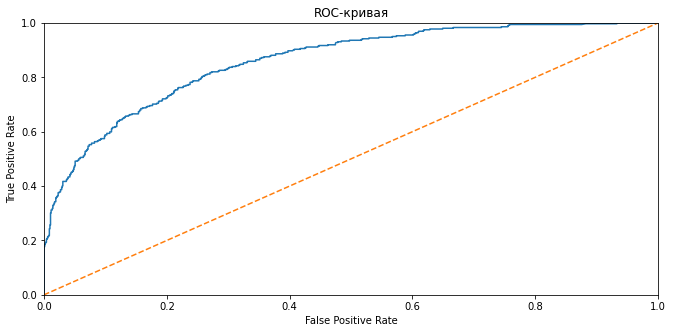

In [46]:
plot_roc_curve(target_test, predicted_probalities)

CatBoostClassifier

In [47]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'iterations': [50, 100],
    'l2_leaf_reg': [3, 9]
}

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]

{'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.3}


ROC-AUC score 0.9116035291572343


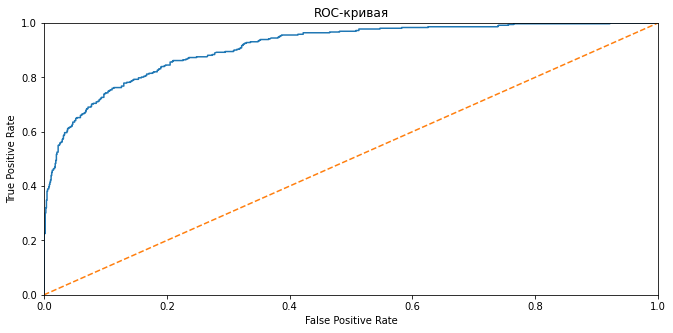

In [48]:
plot_roc_curve(target_test, predicted_probalities)

Catboost показал лучшее значение метрики ROC-AUC - 0.911

In [49]:
importances_df = pd.DataFrame(search.best_estimator_.feature_importances_, index = features_test.columns, columns=['importances'])
importances_df = importances_df.sort_values(by='importances', ascending=False)
importances_df

,importances
totaldays,52.226928
monthlycharges,9.331359
totalcharges,9.149535
type_Two year,4.466679
internetservice_Fiber optic,2.309615
type_One year,2.246386
techsupport_Yes,2.065700
paymentmethod_Electronic check,2.018445
dependents_Yes,1.775840
streamingmovies_Yes,1.713369


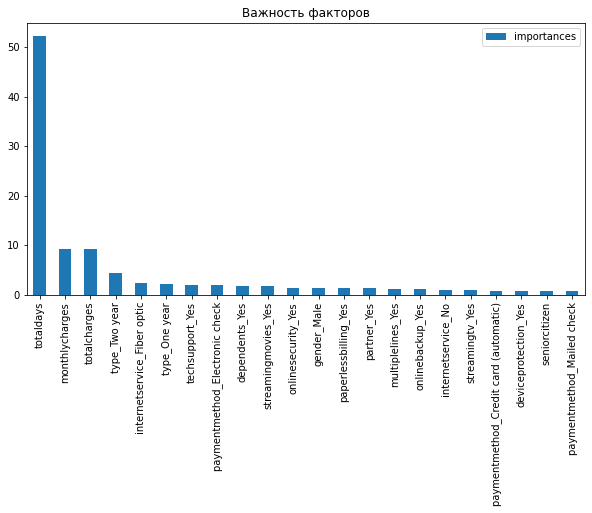

In [50]:
importances_df.plot(kind='bar', figsize=(10, 5), title='Важность факторов')
plt.show()

Самые важные факторы - сколько клиент пользуется услугами и сколько он платит в месяц

## Вывод
- В данной работе проведена работа по предсказанию того, откажется ли клиент от услуг оператора сотовой связи или нет
- Сначала данные были прочитаны и по ним были сделаны предварительные выводы
- После этого была произведена первичная обработка данных - переименованы столбцы, изменены типы данных
- Были добавлены 2 новых столбца - целевой признак сhurn, который означает отказался ли клиент от услуг и totaldays, который обозначает сколько по времени пользователь пользовался услугами
-  Был проведен исследовательский анализ данных - проанализированы количественные и категоральные признаки, проведена попытка найти связь между ними и целевым признаком. Были сделаны следующие выводы: со временем вероятность отказа от услуг снижается и обычно отказывались от услуг те, кто платил больше
- После этого была проведена подготовка данных к обучению моделей: удалены ненужные столбцы, применена техника OHE, датафрейм был разделен на обучающую и тестовую выборки, проведено масштабирование количественных признаков и проведен upsample
- На данных были обучены 3 модели: LogisticRegression, RandomForestClassifier и CatBoostClassifier
- Лучший результат показала модель CatBoostClassifier со значением метрики ROC-AUC в 0.91. 
- Самые важные факторы - сколько клиент пользуется услугами и сколько он платит в месяц